# TP1 Proximal Denoising

* Authors: Mengda Li, Ségolène Martin

## Question 1
Show that this problem amounts to calculate the proximity operator of a
function in $\Gamma_0$.

**_Claim 1.1_**: $f \circ L \in \Gamma_0$

**Proof**:
> 1. Right composition of a convex function by an ffine function is still convex (Proposition 8.20). Since $f \in \Gamma_0$ and $L$ is linear (so affine), $f \circ L$ is convex.
2.  Right composition of a lower semicontinuous function by a continuous function is still lower semicontinuous (Lemma 1.28). Since $f$ is lower semicontinuous and $L$ is continuous (linear and the dimension of its set of departure is finite), $f \circ L$ is lower semicontinuous.
3. $f \circ L$ is clearly proper.

As $f \circ L \in \Gamma_0$, Prox$_{f\circ L}: y \ \mapsto \ \underset{x}{\arg\min} f(Lx) + \frac{1}{2} \|x - y \|^2$ is our goal of optimization problem.

## Question 2
Check that this is also equivalent to calculate $L^{−1} Prox_f (Ly)$.

As $L$ is linear and continuous, $f \in \Gamma_0$, and $LL^* = Id$, (by Proposition 24.14) $Prox_{f \circ L} (y) = y + L^*(Prox_f(Ly) -Ly)$

\begin{align}
Prox_{f \circ L} (y) &= y + L^*(Prox_f(Ly) -Ly) \\
    & = y + L^*(Prox_f(Ly)) - y  \tag*{$(L^*L = Id)$}\\
    & = L^{-1}(Prox_f(Ly)) \tag*{$(L^* = L^{-1})$ }
\end{align}

## Question 3
Download the florence.jpg image. Add to this image a white Gaussian noise
with zero-mean and standard deviation equal to 30.

In [1]:
import imageio
import numpy as np
im = imageio.imread('./florence.jpg')

import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
plt.imshow(im)

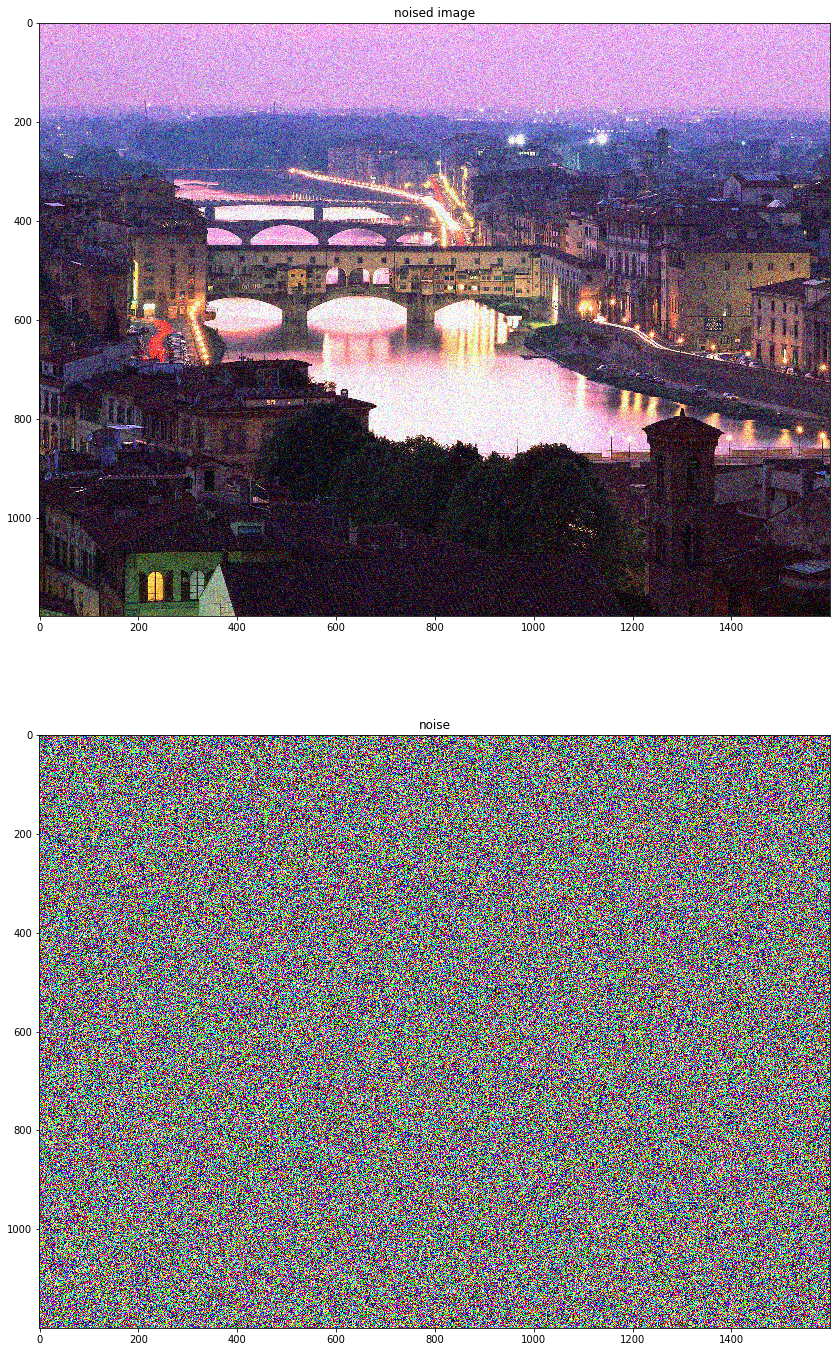

In [2]:
noise = np.random.normal(scale = 30, size = im.shape)
noised = im + noise
noised = np.clip(noised, 0, 255).astype(np.uint8)

f = plt.figure(figsize=(16,24))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax1.set_title('noised image')
ax2.set_title('noise')
ax1.imshow(noised)
noise = noise.astype(np.uint8)
ax2.imshow(noise)

## Question 3 Version 2

In [5]:
import cv2
import pylab as plt
plt.rcParams['figure.figsize'] = [10, 5]
import numpy as np

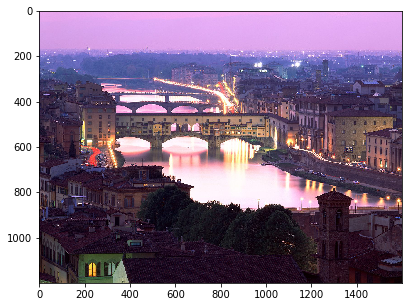

In [6]:
image = cv2.imread('florence.jpg')
image = np.asarray(image, dtype=np.uint8)
im = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.show()


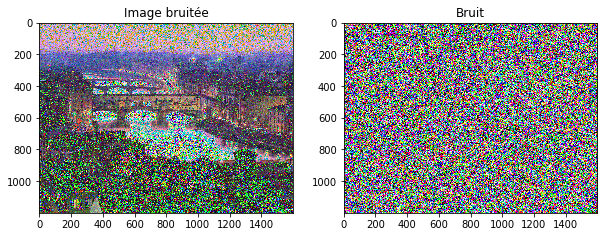

In [7]:
sigma = 30
[nx,ny,nz] = im.shape
#im_bruit = im + np.random.normal(0,30, (nx,ny))
im_bruit = np.zeros((nx, ny, 3))
im_bruit.shape
im_bruit[:,:,0] = np.add(im[:,:,0], np.random.normal(0,sigma, (nx,ny)))
im_bruit[:,:,1] = np.add(im[:,:,1], np.random.normal(0,sigma, (nx,ny)))
im_bruit[:,:,2] = np.add(im[:,:,2], np.random.normal(0,sigma, (nx,ny)))

plt.subplot(1,2,1)
plt.imshow(im_bruit.astype(np.uint8))
plt.title("Image bruitée")
plt.subplot(1,2,2)
plt.imshow((im_bruit-im).astype(np.uint8))
plt.title("Bruit")
plt.show()

## Question 4

Compute the minimizer of (1) when L is a 2D orthonormal wavelet decomposition.

**_Claim 4.1_**: $f_i \in \Gamma_0$

**Proof**:
> 1. $0 \in \Gamma_0$ clearly
2. $\cdot \mapsto | \cdot |$ is convex, $x \mapsto x^q$ is convex and non-decreasing in $\mathbb{R}^+$ for all $q \ge 1$ so $\cdot \mapsto | \cdot |^q$ is still convex. In addition, $\chi > 0$ so $\phi$ is convex. $\phi$ is continuous as composition of continuous functions, and is proper as composition of proper functions.

As $f$ is separable and $f_i \in \Gamma_0$, $Prox_f = (Prox_{f_i})_{i \in [1..N]}$. $Prox_0$ is just identity function while $Prox_\phi$ has a close form in the lecture slide. 

$Ly$ is the 2D wavelet decomposition by some specific wavelet basis (like Haar i.e. db1). We compute the the proximal operator in each level of decomposition: we keep the approximation coefficients because $Prox_0 = Id$ and we compute the value of $Prox_\phi$ on the other sets of coefficients.

After all, we left compose the result by $L^{-1}$ which is the wavelet recompostion of $Prox_f(Ly)$ by the same wavelet basis we used before.

We show some numerical experiments after the code.

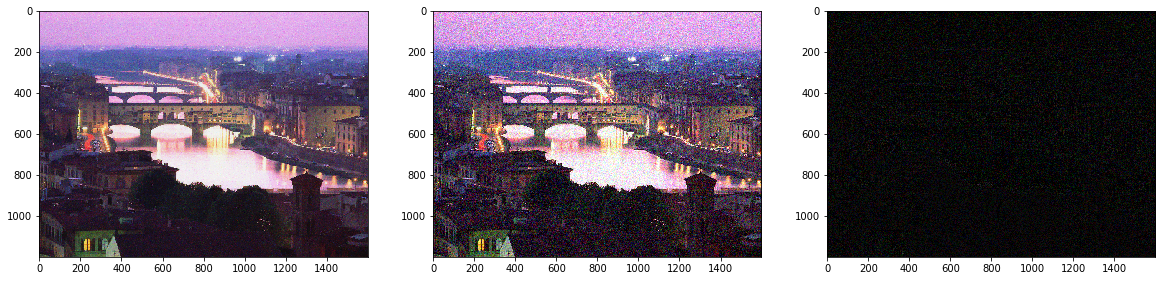

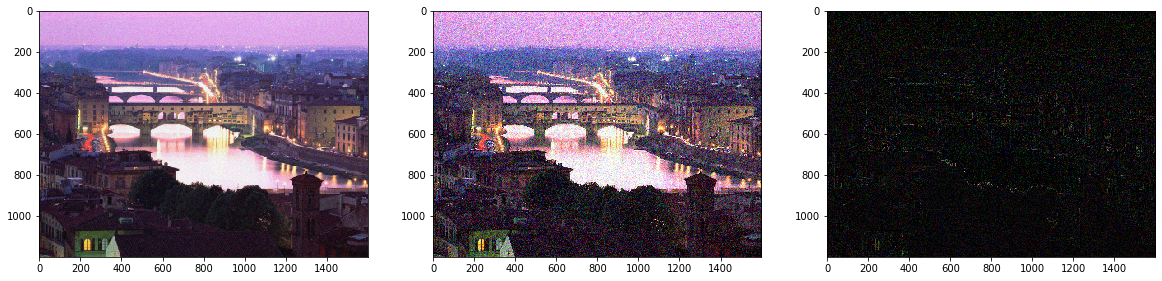

In [3]:
import pywt
plt.rcParams['figure.figsize'] = [20, 10]

def denoising(im, q, chi, l):
    [nx,ny,nz] = im.shape
    denoised = np.zeros((nx, ny, 3))
    for channel in range(3):
        L = pywt.wavedec2(im[:,:,channel], 'db1', axes=(0,1), level=l)
        for level in range(1, l+1):
            L[level] = list(L[level])
            for i in range(3):
                if q == 1 :
                    L[level][i] = np.sign(L[level][i])*np.maximum(abs(L[level][i])-chi,0)
                elif q == 4/3 :
                    eps = np.sqrt(L[level][i]**2 +256*chi**3/729)
                    L[level][i] = L[level][i]+ 4*chi*((eps-L[level][i])**(1/3) - (eps+ L[level][i])**(1/3))/(3*2**(1/3))
                elif q == 3/2 :
                    L[level][i] = L[level][i] + 9* chi**2 * np.sign(L[level][i])*(1-np.sqrt(1+ 16*np.abs(L[level][i])/(9*chi**2)))/8
                elif q == 2 :
                    L[level][i] = L[level][i]/(1+2*chi)
                elif q == 3:
                    L[level][i] = np.sign(L[level][i])*(np.sqrt(1+12*chi*np.abs(L[level][i])) -1)/(6*chi)
                elif q == 4 :
                    eps = np.sqrt(L[level][i]**2 + 1/(27*chi**2))
                    L[level][i] = ((eps + L[level][i])/(8*chi))**(1/3) - ((eps - L[level][i])/(8*chi))**(1/3)
        denoised[:,:,channel] = pywt.waverec2(L, 'db1', axes=(0,1))
        
    return(denoised)

plt.figure(1)
denoised = denoising(noised, 1, 30, 8)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))

plt.figure(2)
denoised = denoising(noised, 2, 10, 2)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))

### Micro optimization of code

In [3]:
import pywt

In [7]:
def denoising(image, q, chi, Level = None, wavelet = 'db1'):
    L = pywt.wavedec2(image, wavelet, axes=(0,1), level=Level)
    for level in range(1, len(L)):
        L[level] = list(L[level])
        for i in range(3):
            Coeff = L[level][i]
            if q == 1 :
                L[level][i] = np.sign(Coeff)*np.maximum(abs(Coeff)-chi,0)
            elif q == 4/3 :
                eps = np.sqrt(Coeff**2 +256*chi**3/729)
                L[level][i] = Coeff+ 4*chi*((eps-Coeff)**(1/3) - (eps+ Coeff)**(1/3))/(3*2**(1/3))
            elif q == 3/2 :
                L[level][i] = Coeff + 9* chi**2 * np.sign(Coeff)*(1-np.sqrt(1+ 16*np.abs(Coeff)/(9*chi**2)))/8
            elif q == 2 :
                L[level][i] = Coeff/(1+2*chi)
            elif q == 3:
                L[level][i] = np.sign(Coeff)*(np.sqrt(1+12*chi*np.abs(Coeff)) -1)/(6*chi)
            elif q == 4 :
                eps = np.sqrt(Coeff**2 + 1/(27*chi**2))
                L[level][i] = ((eps + Coeff)/(8*chi))**(1/3) - ((eps - Coeff)/(8*chi))**(1/3)
    denoised = pywt.waverec2(L, wavelet, axes=(0,1))   
    return(denoised)

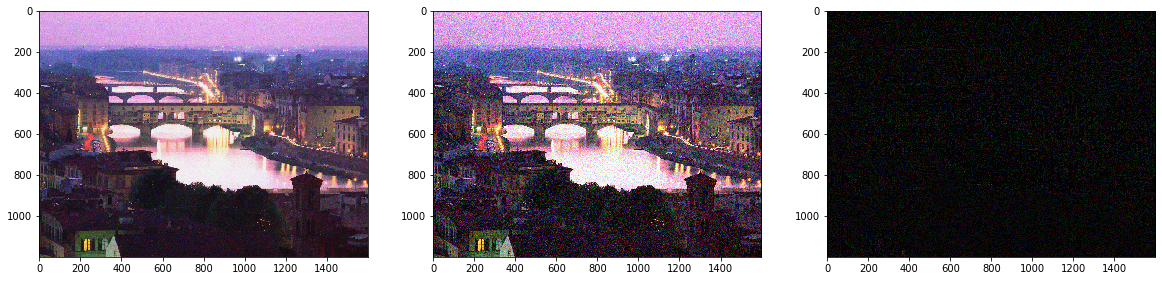

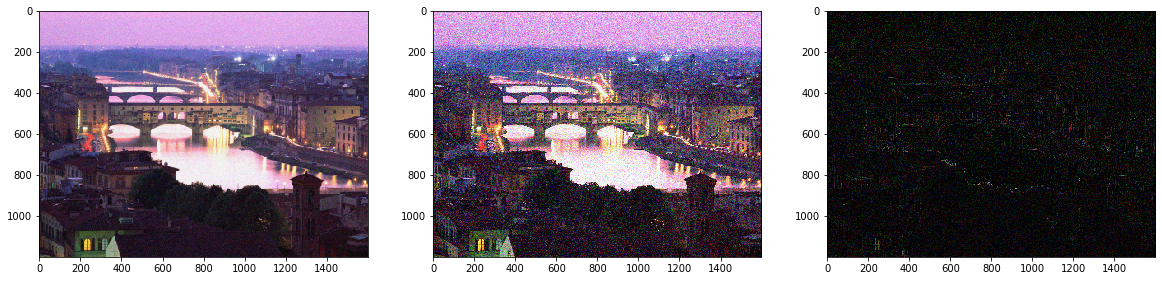

In [10]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.figure(1)
denoised = denoising(noised, 1, 30, 8)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))

plt.figure(2)
denoised = denoising(noised, 2, 10, 2)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))

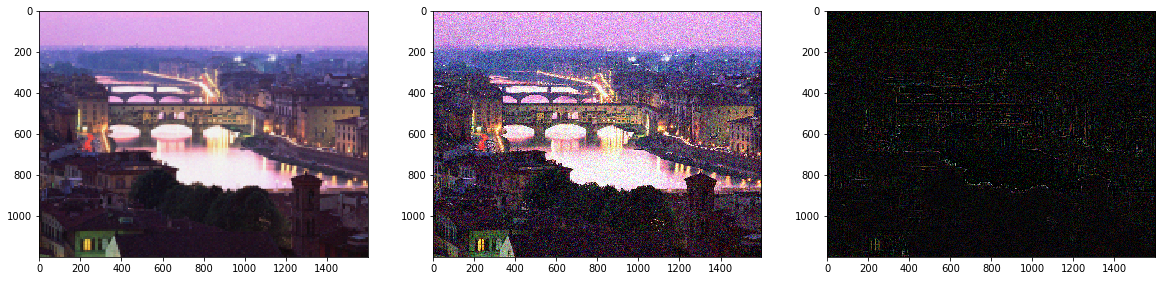

In [12]:
plt.figure(3)
denoised = denoising(noised, 2, 10, 3)
plt.subplot(1,3,1)
plt.imshow(np.clip(denoised, 0, 255).astype(np.uint8))
plt.subplot(1,3,2)
plt.imshow(np.clip(noised, 0, 255).astype(np.uint8))
plt.subplot(1,3,3)
plt.imshow(np.clip(denoised - noised, 0, 255).astype(np.uint8))

Bizzare si trop de niveaux...